# Analyse exploratoire des données audio (EDA)

A62 Projet de synthèse - Groupe 1208<br>
Gabriel Trottier<br>
Guy Raymond<br>
Philip Gaudreau<br>

In [6]:
import os
import re
import string
import glob
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from nltk.corpus import stopwords
from collections import Counter
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## Répertoires des données

In [7]:
text_dir = "../data/raw/text"
labels_dir =  "../data/raw/labels"
audio_dir = "../data/raw/audio"
#audio_clips_dir = "../data/temp/audio_clips"

## Création d'un DataFrame avec tous les labels (classes)

In [8]:
label_files = glob.glob(f"{labels_dir}/*.csv")

df_list = []

for filename in label_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)


df_labels = pd.concat(df_list, axis=0, ignore_index=True)

print(f"Shape des données : {(df_labels.shape[0], df_labels.shape[1])} \n ")
print(f"Noms des colonnes : \n {df_labels.columns.to_list()} \n ")
print(f"Nombre de phrases uniques : {len(df_labels['AssignmentId'].unique())}")

ValueError: No objects to concatenate

# EDA LABELS


In [ ]:
#colonnes ayant des valeurs manquantes et le nombres de valeurs manquantes
nan_cols = [i for i in df_labels.columns if df_labels[i].isnull().any()]
nan_values = [num for num in df_labels.isnull().sum().values if num != 0]



print(pd.DataFrame(np.reshape(nan_values, (19,-1)), columns=[ 'Valeurs manquantes'], index=nan_cols))

Beaucoup de colonnes semblent seulement servir aux annotateurs ou à la gestion/administration de projets et ne concernent donc pas les données en tant que telles. Par exemple, `RequesterAnnotation`,  `CreationTime`, `WorkerID`, les secret words et bien d'autre. 
On voit aussi que plusieurs colonnes sont complètement vides, ayant 100% de valeurs manquantes.
En tout, nous considérons présentement ~25 colonnes comme n'étant d'aucun intérêt ou n'étant pas du tout relié au textes ou clips mêmes et donc notre analyse.

## Selection des colonnes des labels pertinentes pour l'analyse

In [ ]:
"""
useless_cols = ['Answer.secret_word1','Answer.secret_word2','Answer.secret_word3','WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate','HITId', 'HITTypeId','CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds']

df_labels.drop(useless_cols, axis=1, inplace=True)
"""

In [ ]:
label_cols = ['Input.VIDEO_ID', 'Input.CLIP',
              'Answer.anger', 'Answer.disgust',
              'Answer.fear', 'Answer.happiness',
              'Answer.sadness', 'Answer.surprise',
              'Answer.sentiment']

### Noms de colonnes plus faciles à utiliser

In [ ]:
label_new_cols = ['file_id', 'clip_id',
                  'anger', 'disgust',
                  'fear', 'happiness',
                  'sadness', 'surprise',
                  'sentiment']

In [ ]:
emotion_vars = ['Answer.anger', 'Answer.disgust', 'Answer.fear','Answer.happiness', 'Answer.sadness', 'Answer.surprise']
sentiment_var = ['Answer.sentiment']

df_labels[emotion_vars+sentiment_var].describe(percentiles=[0.75])

Annotation des sentiments :  https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf

Si on regarde la moyenne et les centiles 50 et 75, on voit que la très grande majorité des valeurs des émotions/sentiments sont de 0. Seulement les features `sentiment` et `happiness` ont 1 comme valeur pour le 75e centile.

On remarque que les clips vidéos apparaissent 3 fois chacuns, mais les valeurs des variables cibles varient d'une fois à l'autre, donc on en conclu que chaque clip a été annoté 3 fois par des annotateurs différents. Ainsi, on devra combiner les différentes annotations ensemble afin d'obtenir un résultat représentatif des 3 opinions mais qui permet d'associer 1 à 1 avec les fichiers audios.

In [ ]:
df_labels.duplicated(subset=['Input.VIDEO_ID', 'Input.CLIP']).any()
df_labels[['Input.VIDEO_ID','Input.CLIP', 'Answer.anger', 'Answer.disgust', 
'Answer.fear','Answer.happiness', 'Answer.sadness', 
'Answer.surprise', 'Answer.sentiment']].head(24)

In [ ]:
df_labels = df_labels[label_cols]
df_labels.columns = label_new_cols
df_labels.head(5)

,file_id,clip_id,anger,disgust,fear,happiness,sadness,surprise,sentiment
0,c_FJuhSte8Q,6,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
1,c_FJuhSte8Q,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,c_FJuhSte8Q,6,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
3,OOh1_ffKOKk,2,0.0,0.0,0.0,1.0,0.0,0.0,2.0
4,OOh1_ffKOKk,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Affichage des noms de identifiants de fichiers contenant des '/'

In [ ]:
df_labels[df_labels['file_id'].apply(lambda x : '/' in str(x))].tail(10)

,file_id,clip_id,anger,disgust,fear,happiness,sadness,surprise,sentiment
27125,pom_extra/216007,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27126,sqa_mosi/32j1yMF37hA,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27127,sqa_mosi/32j1yMF37hA,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27128,sqa_mosi/32j1yMF37hA,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
27129,sqa_mosi/DbAppk7xT0Y,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27130,sqa_mosi/DbAppk7xT0Y,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27131,sqa_mosi/DbAppk7xT0Y,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27132,sqa_mosi/iREkcXde5ds,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27133,sqa_mosi/iREkcXde5ds,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27134,sqa_mosi/iREkcXde5ds,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Suppression des '/' dans les indentifiants de fichiers pour comparaisons avec audio et textes

In [ ]:
df_labels['file_id'] = df_labels['file_id'].map(lambda x : str(x).split("/")[-1])
df_labels[df_labels['file_id'].apply(lambda x : '/' in str(x))].tail(10)

,file_id,clip_id,anger,disgust,fear,happiness,sadness,surprise,sentiment


In [ ]:
annotated_files = len(df_labels['file_id'].unique())
print(f"Nombre de textes avec au moins un clip annoté: {annotated_files}")

Nombre de textes avec au moins un clip annoté: 3305


## Extraction des informations des clips audio des fichiers texte

In [ ]:
def get_audio_info_from_text(text_dir):
    '''
        get audio information from text files to extract clips
        - clip number
        - clip start time
        - clip end time
        return DataFrame
    '''
    text_files = glob.glob(f"{text_dir}/*.txt")
    df_list = []
    for file in text_files:
        with open(file, 'r') as text_file:
            text_lines = text_file.readlines()
            #df_text = pd.DataFrame()
            text_dict_list = []
            for text_line in text_lines:
                line_dict = {}
                split_line = text_line.split('___')
                line_dict['file_id'] = split_line[0]
                line_dict['clip_id'] = int(split_line[1])
                line_dict['start_time'] = abs(float(split_line[2]))
                line_dict['end_time'] = float(split_line[3])
                
                # leave text out for now
                # line_dict['text'] = split_line[4][:-1]
                
                text_dict_list.append(line_dict)
        df_list.append(pd.DataFrame(text_dict_list))
    df = pd.concat(df_list, axis=0, ignore_index=True)
    return df

## Fichiers bruts

In [ ]:
audio_info = get_audio_info_from_text(text_dir)
print(f"Nombre de fichiers textes                        : ",
      f"{len(audio_info['file_id'].unique())}")
print(f"Nombre de clips (phrases) extraits des textes    : {audio_info.shape[0]}")
print(f"Nombre de clips (phrases) moyen par fichier texte:   ",
      f"{round(audio_info.shape[0]/len(audio_info['file_id'].unique()))}")

Nombre de fichiers textes                        :  3837
Nombre de clips (phrases) extraits des textes    : 44977
Nombre de clips (phrases) moyen par fichier texte:    12


In [ ]:
audio_info.head()

,file_id,clip_id,start_time,end_time
0,xYtNgq9eTlg,0,0.000,17.943
1,xYtNgq9eTlg,1,17.342,25.376
2,xYtNgq9eTlg,2,24.755,30.255
3,xYtNgq9eTlg,3,29.554,36.331
4,xYtNgq9eTlg,4,35.700,39.494


In [ ]:
def get_audio_file_ids(audio_dir):
    '''
        audio_dir: répertoire contenant les fichiers audio
        retrourne le nom des fichiers du répertoire (sans .wav)
    '''
    file_ids = []
    audio_files = glob.glob(f"{audio_dir}/*.wav")
    for file in audio_files:
        file_ids.append(file.split('/')[-1].split('.')[0])
    return file_ids

In [ ]:
audio_ids = get_audio_file_ids(audio_dir)
print(f"{len(audio_ids)} fichiers audio dans {audio_dir}")

3837 fichiers audio dans ../data/raw/audio


On voit que le nombre de fichiers audio et texte concordent.

In [ ]:
def compare_ids(ids_list1, ids_list2):

    ids1_not_in_ids2 = []
    for i in ids_list1:
        if i not in ids_list2:
            ids1_not_in_ids2.append(i)
    return ids1_not_in_ids2

In [ ]:
audio_not_in_text = \
    compare_ids(audio_ids, audio_info['file_id'].values)
print("Nombre de fichiers audios n'apparaissant pas dans les textes: ",
      len(audio_not_in_text))
text_not_in_audio = \
    compare_ids(audio_info['file_id'].values, audio_ids)
print(f"Fichiers textes n'apparaissant pas dans les fichiers audio  : ",
      len(text_not_in_audio))

Nombre de fichiers audios n'apparaissant pas dans les textes:  0
Fichiers textes n'apparaissant pas dans les fichiers audio  :  0


## Fichiers audio n'étant pas étiquetés (pas dans labels)

In [ ]:
print("Nombre de fichiers audio avant séparation en clips             : ",
      len(audio_ids))
files_not_in_labels = \
    compare_ids(audio_ids, df_labels['file_id'].values)
print("Nombre de fichiers audio n'apparaissant pas dans les labels    :  ",
      len(files_not_in_labels))

files_labeled = len(audio_ids) - len(files_not_in_labels)
print("Nombre de fichiers audio ayant au moins un clip dans les labels: ",
      files_labeled)

Nombre de fichiers audio avant séparation en clips             :  3837
Nombre de fichiers audio n'apparaissant pas dans les labels    :   532
Nombre de fichiers audio ayant au moins un clip dans les labels:  3305


## Calcul de la longueur des clips

In [ ]:
audio_info['clip_len'] = \
    audio_info.apply(lambda x : x['end_time'] - x['start_time'], axis=1)

In [ ]:
clips_count = audio_info['file_id'].value_counts()
# print(clips_count[:5])
# print(clips_count[-5:])
print("")
print(f"Nombre total de clips (phrases)   : {clips_count.sum()}")
print(f"Nombre moyen de clips par fichier : {round(clips_count.mean(), 1)}")
print(f"Nombre médian de clips par fichier: {clips_count.median()}")


Nombre total de clips (phrases)   : 44977
Nombre moyen de clips par fichier : 11.7
Nombre médian de clips par fichier: 10.0


In [ ]:
no_label_clips = []
no_label_index = []
for f in audio_ids:
    df_aud = audio_info[audio_info['file_id'] == f]
    file_clips = df_aud['clip_id'].to_list()
    df_lab = df_labels[df_labels['file_id'] == f]
    for c in file_clips:
        if df_lab[df_lab['clip_id'] == c]['file_id'].count() == 0:
            no_label_clips.append([f, c])
            no_label_index.append(audio_info[(audio_info['file_id'] == f) & \
                                    (audio_info['clip_id'] == c)].index[0])

## DataFrame contenant les clips annotés seulement

In [ ]:
audio_labeled = audio_info.drop(index=no_label_index)
audio_labeled.head()

,file_id,clip_id,start_time,end_time,clip_len
0,xYtNgq9eTlg,0,0.000,17.943,17.943
1,xYtNgq9eTlg,1,17.342,25.376,8.034
2,xYtNgq9eTlg,2,24.755,30.255,5.500
3,xYtNgq9eTlg,3,29.554,36.331,6.777
4,xYtNgq9eTlg,4,35.700,39.494,3.794


## Temps total des clips annotés

In [ ]:
def convert_secs(seconds):
    min, sec = divmod(seconds, 60)
    hour, min = divmod(min, 60)
    return "%d:%02d:%02d" % (hour, min, sec)

In [ ]:
tot_clips = audio_info.shape[0]
not_annot_clips = len(no_label_clips)
annot_clips = tot_clips - not_annot_clips
print(f"Nombre total de clips        : {tot_clips}")
print(f"Nombre de clips non-annotés  : {not_annot_clips}")
print(f"Nombre de clips annotés      : {annot_clips}")
print("Pourcentage de clips annotés :",
      f"{round(annot_clips/tot_clips * 100,2)} %")
time_clips_labeled = convert_secs(audio_labeled['clip_len'].sum())
print(f"Temps des clips annotés      : {time_clips_labeled} heures")

Nombre total de clips        : 44977
Nombre de clips non-annotés  : 21718
Nombre de clips annotés      : 23259
Pourcentage de clips annotés : 51.71 %
Temps des clips annotés      : 49:04:41 heures


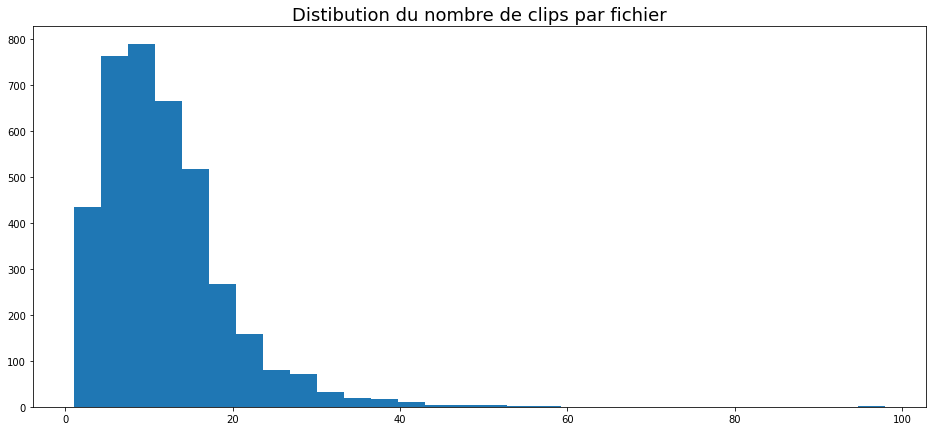

In [ ]:
plt.figure(figsize=(16, 7))
plt.title("Distibution du nombre de clips par fichier", fontsize=18)
plt.hist(clip_count, bins=30)
plt.show()

In [ ]:
print(clip_count[clip_count > 50])

266396         98
Wx9nThz5z_Y    58
266938         55
YcJ5RJYUr7Y    53
ogGweZUAVtU    52
j1m6ctAgjsM    52
Name: file_id, dtype: int64


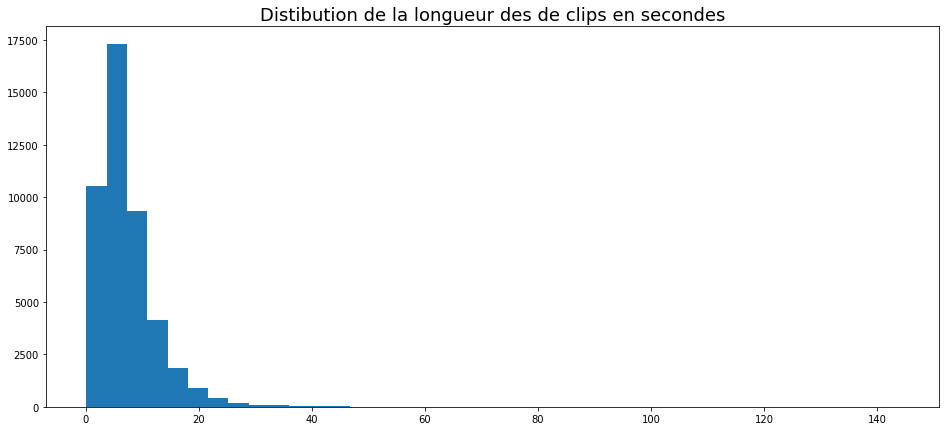

In [ ]:
len_bins = 40
plt.figure(figsize=(16, 7))
plt.title("Distibution de la longueur des de clips en secondes", fontsize=18)
plt.hist(audio_info['clip_len'], bins=len_bins)
plt.show()

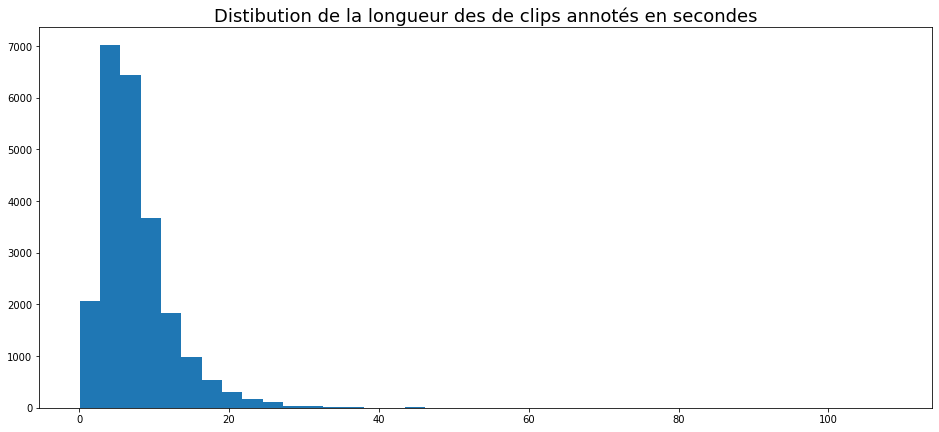

In [ ]:
len_bins = 40
plt.figure(figsize=(16, 7))
plt.title("Distibution de la longueur des de clips annotés en secondes", fontsize=18)
plt.hist(audio_labeled['clip_len'], bins=len_bins)
plt.show()

In [ ]:
print(f"Longueur moyenne des clips : {audio_info['clip_len'].mean()} sec.")
print(f"Longueur médiane des clips : {audio_info['clip_len'].median()} sec.")
print(f"Longueur minimale des clips: {audio_info['clip_len'].min()} sec.")
print(f"Longueur maximale des clips: {audio_info['clip_len'].max()} sec.")

Longueur moyenne des clips : 7.3610167255050305 sec.
Longueur médiane des clips : 6.0185941043 sec.
Longueur minimale des clips: 0.11972789120000016 sec.
Longueur maximale des clips: 143.656 sec.


# EDA STRICTEMENT TEXTE

In [ ]:
text_files = glob.glob(f"{text_dir}/*.txt")

def remove_stamps_str(line)->str:
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line

## REVOIR, long

In [ ]:
text_list = []
for filename in text_files:
    text = ''
    with open(file=filename, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            clean_line = remove_stamps_str(line)
            text += clean_line
    text_list.append(text.splitlines())


### Fonctions de nettoyage

In [ ]:
def avg_count(l1:list):
    word_count = 0
    for e in l1:
        word_count += len(e.split())
    return int(word_count/len(l1))

text_files = glob.glob(f"{text_dir}/*.txt")
stop_words = stopwords.words('English')

#création d'un dict pour lookup en O(1)
stopwords_dict = Counter(stop_words)


#Retire tous les timestamps en début de ligne, présents dans chaque transcript
def remove_stamps_str(line)->str:
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line

#Retire les charactères non-ascii 
def remove_non_ascii(line)->str:
    ascii_line = line.encode(encoding = 'ascii', errors = 'ignore').decode()
    return ascii_line

#met tout en minuscules, retire les nombres et stopwords
def clean_stopwords_digits(line)->str:
    new_line = ' '.join([word.lower() for word in line.split() if (len(word) >=2 and word.isalpha() and word not in stopwords_dict)])
    return new_line







In [ ]:
df_text = pd.DataFrame((np.array(text_list, dtype= object)).reshape(-1))
df_text.columns = ['raw_text']
df_text['tokens'] = df_text['raw_text'].apply(lambda l : word_tokenize(' '.join(l)))

df_text['lines'] = df_text['raw_text'].apply(lambda x : len(x))
df_text['avg_count'] = df_text['raw_text'].apply(avg_count)
df_text['word_count'] = df_text['tokens'].apply(len)
df_text['raw_text'] = df_text['raw_text'].apply(lambda x : ' '.join(x))
df_text['cleaned_text'] = df_text['raw_text'].apply(clean_stopwords_digits)

#words_lengths = df_text['tokens'].apply(lambda array : list(map(len, array))).explode()

In [ ]:
wordcount = df_text['cleaned_text'].str.split(expand=True).stack().value_counts()
wordcount

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', stopwords=stop_words,
                
                min_font_size = 10).generate_from_frequencies(wordcount)

plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

nettoyage initial

In [ ]:

"""

def list_files_paths(root_dir):
    files_paths = []
    for subdir, dirs, files in os.walk(root_dir):
        for filename in files:
            file_path = os.path.join(subdir, filename)
            files_paths.append(file_path)
    return files_paths

def list_filenames(root_dir):
    filenames = []
    for subdir, dirs, files in os.walk(root_dir):
        for filename in files:
            filenames.append(filename)
    return filenames




def clean_text(text_file):
    cleaned_text = ''
    with open(text_dir+text_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            
            #timestamps en début de ligne
            stamp = re.search('.+___', line).group(0)
            
            #retrait des timestamps et élimine tous les "mots" qui sont en fait des nombres
            newline = ' '.join([word.lower() for word in line.strip(stamp).split() if (word.isalpha() and word not in stopwords_dict)]) + '\n'

            # méthode alternative pour retirer les charactères
            #newline = re.sub(r'[^\x00-\x7f]','',newline)

            #Tous les charactères non-ASCII sont retirés
            decoded_line = newline.encode(encoding='ascii', errors='ignore').decode()
            cleaned_text += decoded_line
    return cleaned_text
"""

def copy_clean_file(text_file, target_directory):
    with open(target_directory+text_file, 'w', encoding='utf-8') as f_out:
        f_out.write(clean_text(text_file))


def clean_corpus(source_directory, target_directory):
    for filename in list_filenames(source_directory):
        copy_clean_file(filename, target_directory)

#clean_corpus(text_dir, cleaned_dir)